In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import cv2
import os 
import sys
import pathlib

# Pretrained models for transfer learning

### Monkey Dataset

The dataset consists of two files, training and validation. Each folder contains 10 subforders labeled as n0~n9, each corresponding a species form Wikipedia's monkey cladogram.

```
Label mapping:
n0, alouatta_palliata
n1, erythrocebus_patas
n2, cacajao_calvus 
n3, macaca_fuscata   
n4, cebuella_pygmea
n5, cebus_capucinus
n6, mico_argentatus
n7, saimiri_sciureus 
n8, aotus_nigriceps
n9, trachypithecus_johnii
```

In [2]:
data_dir = pathlib.Path("../data/10-monkey-species")
image_count = len(list(data_dir.glob('**/*/*.jpg')))

In [3]:
str(list(data_dir.glob('**//*/training'))[0])

'..\\data\\10-monkey-species\\training\\training'

In [4]:
# Finding all the class names for the image classification task
CLASS_NAMES = np.array([item.name for item in data_dir.glob('**//*/training/*')])
CLASS_NAMES

array(['n0', 'n1', 'n2', 'n3', 'n4', 'n5', 'n6', 'n7', 'n8', 'n9'],
      dtype='<U2')

In [5]:
# Display various sample files from each class
import IPython.display as display
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [6]:
# Keras.preprocessing
# The 1./255 is to convert from uint8 to float32 in range [0,1].
image_generator = keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

BATCH_SIZE = 32
# For VGG19 the input shape and size by deafult is 244,244 and hence the same is kept
IMG_HEIGHT = 224 # This should map with the height and width of the pretrained model
IMG_WIDTH = 224 # This should map with the height and width of the pretrained model
STEPS_PER_EPOCH = np.ceil(image_count/BATCH_SIZE)

train_data_gen = image_generator.flow_from_directory(directory=str(list(data_dir.glob('**//*/training'))[0]),
                                                     batch_size=BATCH_SIZE,
                                                     shuffle=True,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     classes = list(CLASS_NAMES))

Found 1098 images belonging to 10 classes.


<center><img src='https://miro.medium.com/max/841/1*HpvpA9pBJXKxaPCl5tKnLg.jpeg' height =150 weight=150> </center>


In [7]:
# We can inspect how a batch is created
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(25):
        ax = plt.subplot(5,5,n+1)
        # plt.imshow(cv2.cvtColor(image_batch[n], cv2.COLOR_BGR2RGB))
        plt.imshow(image_batch[n])
        plt.title(CLASS_NAMES[label_batch[n]==1][0].title())
        plt.axis('off')

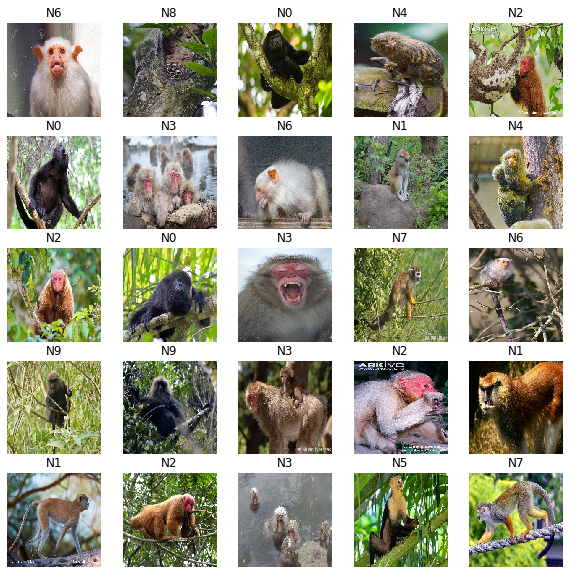

In [8]:
# Since the function returns a generator we can use a next call on the object to generate a batch
image_batch, label_batch = next(train_data_gen)
show_batch(image_batch, label_batch)
#note make sure you call the iterator again before going for training

In [9]:
# We can do a similar process using tf.data pipeline as well
list_ds = tf.data.Dataset.list_files(str(data_dir/'*/training/*/*'))
# The image generator class in keras maps the images to its respective folder
# To do the same in tfds let us create a function
# For this we use Dataset.map

def get_label(file_path):
    # convert the path to a list of path components
    parts = tf.strings.split(file_path, os.path.sep)
    # The second to last is the class-directory
    return parts[-2] == CLASS_NAMES

def decode_img(img):
    # convert the compressed string to a 3D uint8 tensor
    img = tf.image.decode_jpeg(img, channels=3)
    # Use `convert_image_dtype` to convert to floats in the [0,1] range.
    img = tf.image.convert_image_dtype(img, tf.float32)
    # resize the image to the desired size.
    return tf.image.resize(img, [IMG_WIDTH, IMG_HEIGHT])

def process_path(file_path):
    label = get_label(file_path)
    # load the raw data from the file as a string
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img, label

The number of elements to prefetch should be equal to (or possibly greater than) the number of batches consumed by a single training step. You could either manually tune this value, or set it to tf.data.experimental.AUTOTUNE which will prompt the tf.data runtime to tune the value dynamically at runtime.

<center><img src='https://www.tensorflow.org/guide/images/data_performance/prefetched.svg' height =150 weight=150> </center>


In [10]:
# Set `num_parallel_calls` so multiple images are loaded/processed in parallel.
AUTOTUNE = tf.data.experimental.AUTOTUNE
labeled_ds = list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [11]:
for image, label in labeled_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (224, 224, 3)
Label:  [False False False False False False  True False False False]


In [12]:
def prepare_for_training(ds,shuffle_buffer_size=1000):
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    # Repeat forever
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    
    # `prefetch` lets the dataset fetch batches in the background while the model
    # is training.
    #ds = ds.prefetch(1)
    return ds

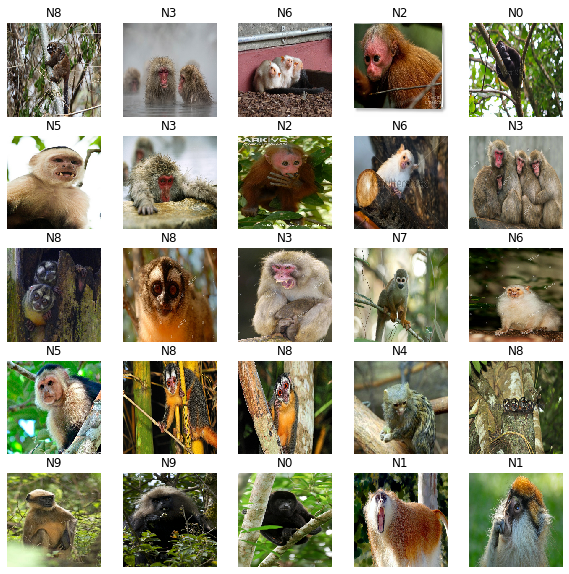

In [13]:
train_ds = prepare_for_training(labeled_ds)

image_batch, label_batch = next(iter(train_ds))
show_batch(image_batch.numpy(), label_batch.numpy())

In [1]:
import tensorflow as tf

## Transfer learning

We are going to use the VGG19 model for showcasing the transfer learning

One can utilize the tf.keras.applications object to download the VGG19 model in Keras format with trained parameters. To do so, run the following code:

In [14]:
IMG_SHAPE = (224, 224, 3)
base_model = tf.keras.applications.vgg19.VGG19(weights='imagenet', include_top=False, input_shape=IMG_SHAPE)


80142336/80134624 [==============================] - 18s 0us/step


- The weights argument ‘imagenet’ denotes that the weights to be used are those generated by being trained on the ImageNet dataset. 

- The include_top argument states that we only want the CNN-feature maps part of the VGG19 model – not its final GAP and dense connected layers. 

- Finally, we need to specify what input shape we want the model being setup to receive. 

- Next, we need to disable the training of the parameters within this Keras model.

In [15]:
# At the begining of training we need to freeze the weights of pretrained layers
for layer in base_model.layers:
    layer.trainable = False

In [ ]:
# base_model.trainable=False

In [16]:
avg = keras.layers.GlobalAveragePooling2D()(base_model.output)
output = keras.layers.Dense(len(CLASS_NAMES), activation="softmax")(avg)
model = keras.Model(inputs=base_model.input, outputs=output)

In [17]:
# Let's take a look at the base model architecture
base_model.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [18]:
# Let's take a look at the final model architecture
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [19]:
optimizer = keras.optimizers.SGD(lr=0.2, momentum=0.9, decay=0.01)

model.compile(loss="categorical_crossentropy", optimizer=optimizer,metrics=["accuracy"])


In [20]:
train_image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255) # Generator for our training data
validation_image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255) # Generator for our validation data


BATCH_SIZE = 32
# For VGG19 the input shape and size by deafult is 244,244 and hence the same is kept
IMG_HEIGHT = 224 # This should map with the height and width of the pretrained model
IMG_WIDTH = 224 # This should map with the height and width of the pretrained model
STEPS_PER_EPOCH = np.ceil(image_count/BATCH_SIZE)


In [21]:
train_data_gen = train_image_generator.flow_from_directory(directory=str(list(data_dir.glob('**//*/training'))[0]),
                                                     batch_size=BATCH_SIZE,
                                                     shuffle=True,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     classes = list(CLASS_NAMES))

Found 1098 images belonging to 10 classes.


In [22]:
val_data_gen = validation_image_generator.flow_from_directory(directory=str(list(data_dir.glob('**//*/validation'))[0]),
                                                     batch_size=BATCH_SIZE,
                                                     shuffle=True,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     classes = list(CLASS_NAMES))

Found 272 images belonging to 10 classes.


In [25]:
TOTAL_TRAIN = len(list(data_dir.glob('**//*/training/*/*.jpg')))
TOTAL_VAL = len(list(data_dir.glob('**//*/validation/*/*.jpg')))
EPOCHS = 1


In [26]:
history = model.fit_generator(
    train_data_gen,
    steps_per_epoch=TOTAL_TRAIN // BATCH_SIZE, # we can also cover x% of the data
    epochs=EPOCHS,
    validation_data=val_data_gen,
    validation_steps=TOTAL_VAL // BATCH_SIZE
)

 1/34 [..............................] - ETA: 1:19:43 - loss: 8.2953 - accuracy: 0.1250

KeyboardInterrupt: 

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


We can unfreeze the top layers on training and continue training (don’t forget to compile the model when you freeze or unfreeze layers). 
This time we use :-
- A much lower learning rate to avoid damaging the pretrained weights
 

In [ ]:
for layer in base_model.layers:
    layer.trainable = True

optimizer = keras.optimizers.SGD(learning_rate=0.01, momentum=0.9,
                                 nesterov=True, decay=0.001)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])

In [ ]:
history = model.fit_generator(
    train_data_gen,
    steps_per_epoch=TOTAL_TRAIN // BATCH_SIZE, # we can also cover x% of the data
    epochs=EPOCHS+20,
    validation_data=val_data_gen,
    validation_steps=TOTAL_VAL // BATCH_SIZE
)